### K-Means clustering

What is K-means? It is an unsupervised ML method. It computes the centroids and iterates until it finds optimal centroid. In this algorithm, the data points are assigned to a cluster in such a manner that the sum of the squared distance between the data points and centroid would be minimum.

What is a cluster exactly? A cluster refers to a collection of data points aggregated together because of certain similarities.
How about centroids? Think of it as the center location of the cluster.

For more information on how k-means work, refer to this [link](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

Now, when it comes to clustering. There are 3 popular types to conside:
1. Partitional clustering
2. Hierachical clustering
3. Density-based clustering

Partitional clustering groups the data objects into non-overlapping groups, so every cluster must have its own data point (one or more). These techniques require the user to specify the number of clusters, indicated by the variable k. Many partitional clustering algorithms work through an iterative process to assign subsets of data points into k clusters. Two examples of partitional clustering algorithms are k-means and k-medoids.

Is k-means deterministic? Meaning given a particular input, will it always produce the same output? No, it is not.

### 1. Loading data and Exploratory Data Analysis

In [1]:
# Import libraries
# for basic mathematics operation 
import numpy as np
import pandas as pd
from pandas import plotting
from sklearn.preprocessing import StandardScaler

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

C:\Users\User\miniconda3\envs\PythonCPU\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("./kmeans_data/OnlineRetail.csv", encoding= 'unicode_escape')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Notice that the min quantity has negative values, this might be an error that could be detrimental, so as the unit price, as it has negative value.

For this work, I am going to assume this is an error, and convert the values to be positive. 

In [5]:
df['Quantity'] = df['Quantity'].abs()
df['UnitPrice'] = df['UnitPrice'].abs()

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,11.340487,4.692766,15287.690570
std,217.995482,96.755927,1713.600303
min,1.000000,0.000000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Now, that makes more sense, but apparently there is a unit price of 0.00? Meaning it is free, I'll let this one slide

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
# checking if there is any NULL data
df.isnull().any().any()

True

In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Well, it seems like there is some missing data for description, and customer IDs. There isn't much I can do to impute the missing values for these 2 columns. So I am going to remove them.

In [10]:
# Droping rows having missing values
df = df.dropna()
df.shape

(406829, 8)

In [11]:
column = df.columns

In [12]:
# Quick inspection of the number of unique values ine each column and what the values are, limit to 5 max.
print("Number of unique values in each column followed by its values \n")
for column in df:
    print(column +  ": %d, %s" %(len(df[column].unique()), df[column].unique()[:4]))

Number of unique values in each column followed by its values 

InvoiceNo: 22190, ['536365' '536366' '536367' '536368']
StockCode: 3684, ['85123A' '71053' '84406B' '84029G']
Description: 3896, ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' 'KNITTED UNION FLAG HOT WATER BOTTLE']
Quantity: 310, [ 6  8  2 32]
InvoiceDate: 20460, ['01-12-2010 08:26' '01-12-2010 08:28' '01-12-2010 08:34'
 '01-12-2010 08:35']
UnitPrice: 620, [2.55 3.39 2.75 7.65]
CustomerID: 4372, [17850. 13047. 12583. 13748.]
Country: 37, ['United Kingdom' 'France' 'Australia' 'Netherlands']


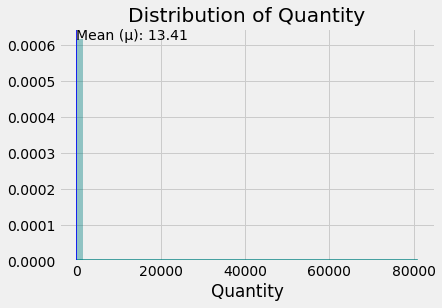

In [13]:
plt.style.use("fivethirtyeight")
sns.distplot(df['Quantity'], color='teal', kde=True)
plt.axvline(df['Quantity'].mean(), color='blue', linestyle='-', linewidth=0.8)
min_ylim, max_ylim = plt.ylim()
plt.text(df['Quantity'].mean()*1.05, max_ylim*0.95, 'Mean (μ): {:.2f}'.format(df['Quantity'].mean()))
plt.xlabel("Quantity")
plt.title(f"Distribution of Quantity")
plt.show()

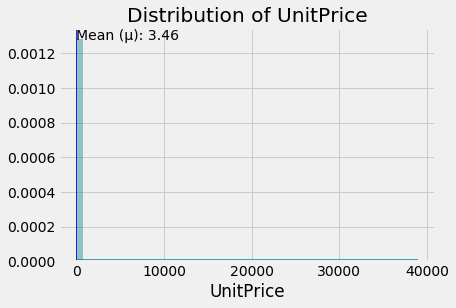

In [14]:
plt.style.use("fivethirtyeight")
sns.distplot(df['UnitPrice'], color='teal', kde=True)
plt.axvline(df['UnitPrice'].mean(), color='blue', linestyle='-', linewidth=0.8)
min_ylim, max_ylim = plt.ylim()
plt.text(df['UnitPrice'].mean()*1.05, max_ylim*0.95, 'Mean (μ): {:.2f}'.format(df['UnitPrice'].mean()))
plt.xlabel("UnitPrice")
plt.title(f"Distribution of UnitPrice")
plt.show()

Seems like both quantity and unit prices are heavily right skewed. Regardless, a new column can be created using this

In [15]:
# new column: amount 
df['amount'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [16]:
rfm_m = df.groupby('CustomerID')['amount'].sum().reset_index()
rfm_m.head()

,CustomerID,amount
0,12346.0,154367.20
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


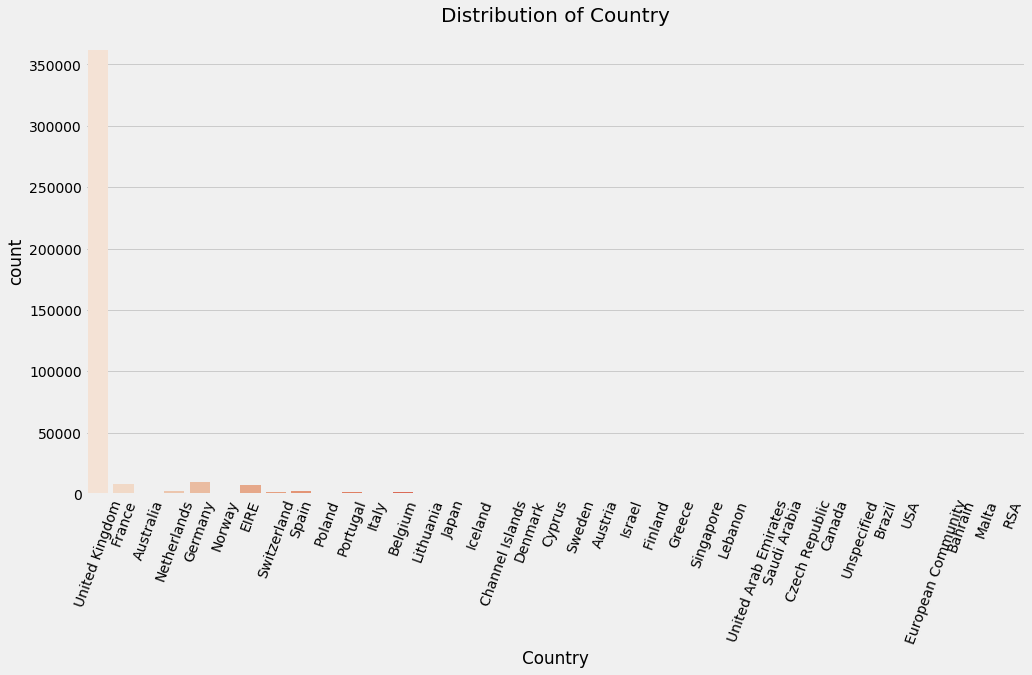

In [17]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(df['Country'], palette = 'rocket_r')
plt.title('Distribution of Country', fontsize = 20)
plt.xticks(rotation = 70)
plt.show()

In [18]:
df['Amount'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,154367.20
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [19]:
# frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'frequency']
rfm_f.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,frequency
0,12346.0,154367.20,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [21]:
# recency
# convert to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

# compute the max date
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [22]:
# compute the diff
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00


In [23]:
# calculate recency for each unique customers
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [24]:
# merge
grouped_df = pd.merge(rfm, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,154367.20,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [25]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,154367.20,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### Outlier detection

Text(0.5, 0, 'Attributes')

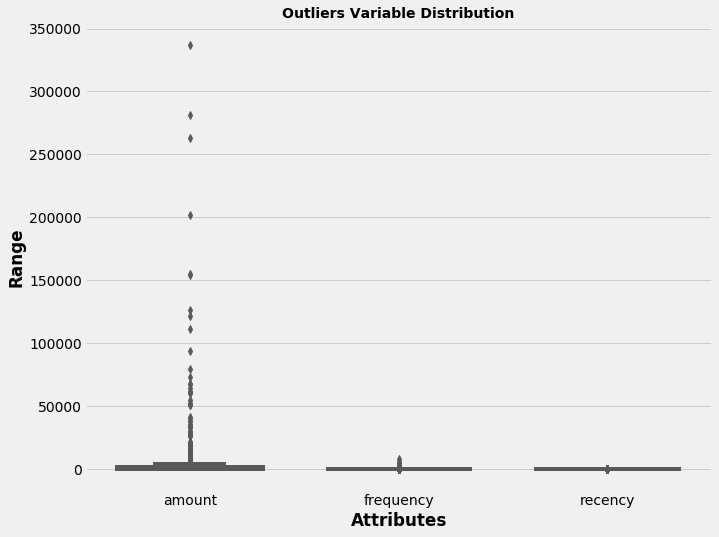

In [26]:
# Outlier Analysis of Amount Frequency and Recency
attributes = ['amount','frequency','recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = grouped_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [27]:
# Removing (statistical) outliers for Amount
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

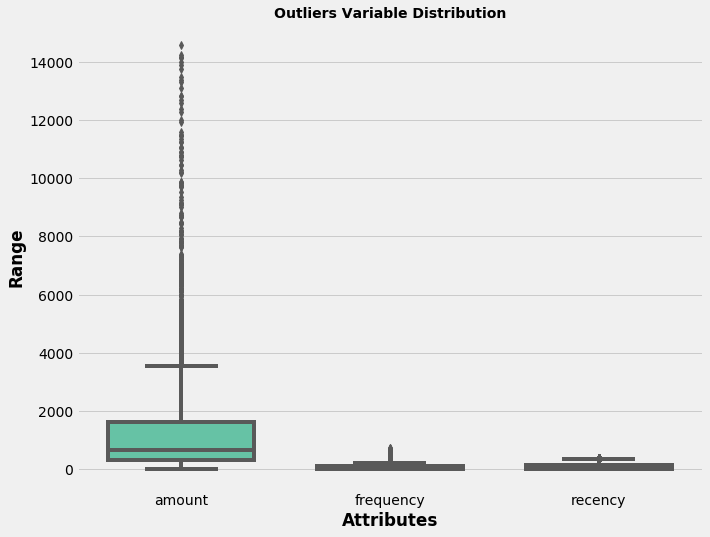

In [28]:
# Outlier Analysis of Amount Frequency and Recency
attributes = ['amount','frequency','recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = grouped_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Clustering algorithms such as K-means do need feature scaling before they are fed to the algo. So we are going to use StandardScaler to scale the values

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance.

In [29]:
# Rescaling the attributes
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4287, 3)

In [30]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,1.617964,1.042924,-0.906582
1,0.250023,-0.463321,-0.183601
2,0.228416,-0.044366,-0.738216
3,-0.546344,-0.602973,2.143802
4,1.158857,0.175087,-0.569851


### 2. K-means clustering

In [31]:
# k-means with some arbitrary k
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

# assign the label
# rfm['Cluster_Id'] = kmeans.labels_
# rfm.head()

KMeans(max_iter=50, n_clusters=4)

In [32]:
kmeans.labels_

array([2, 1, 1, ..., 0, 1, 1])

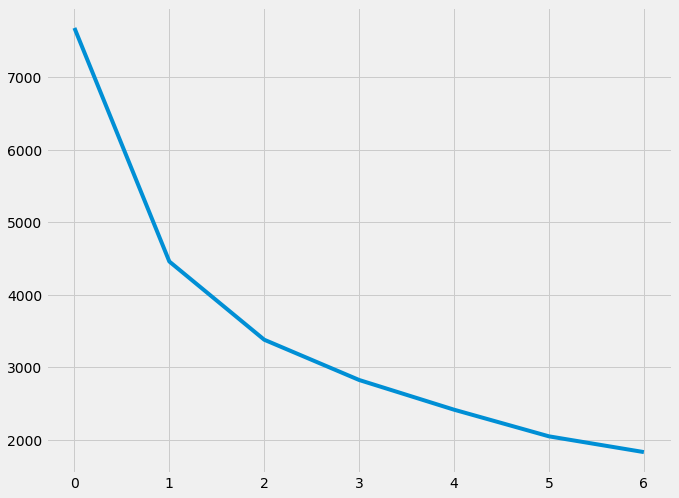

In [33]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

#### Silhouette Analysis


In [35]:
# silhouette analysis
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5385620624030084
For n_clusters=3, the silhouette score is 0.5082464788762033
For n_clusters=4, the silhouette score is 0.485855656120427
For n_clusters=5, the silhouette score is 0.47209965876837673
For n_clusters=6, the silhouette score is 0.41632676161987014
For n_clusters=7, the silhouette score is 0.4155889281071188
For n_clusters=8, the silhouette score is 0.4061759980219593


In [36]:
# final model with k=3
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=2)

In [37]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0
5,12352.0,3466.67,95,35,0


In [40]:
### visualize the result
import plotly.express as px
grouped_df["cluster_id"] = grouped_df["cluster_id"].astype(str) #convert to string
fig = px.scatter_3d(grouped_df, x='recency', y='frequency', z='amount',
              color='cluster_id')
fig.show()

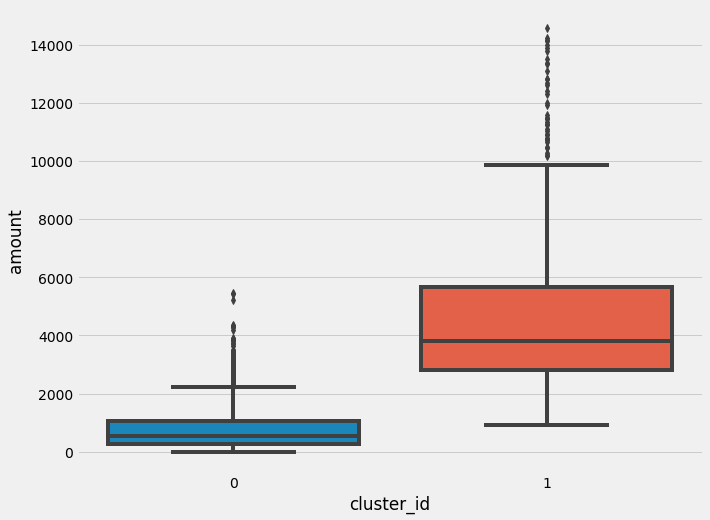

In [41]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

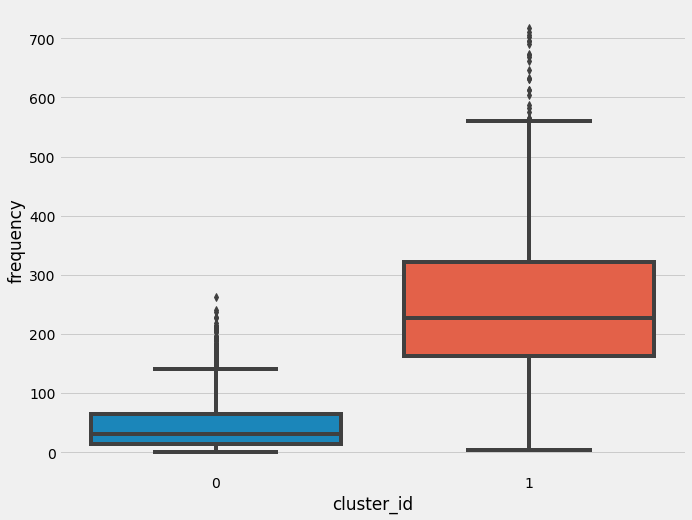

In [42]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

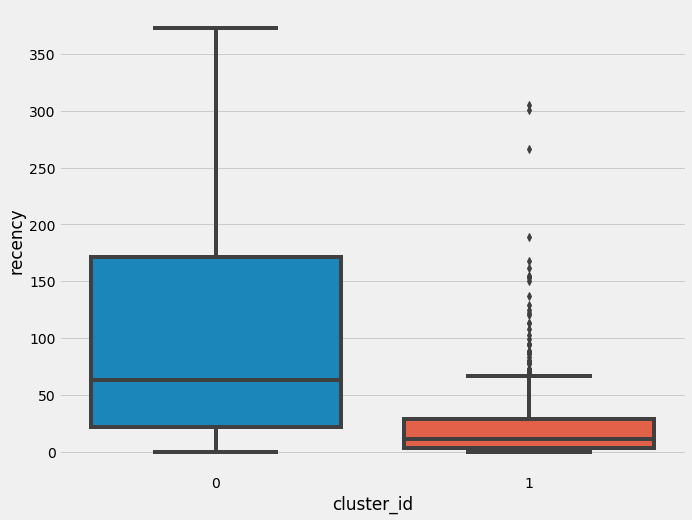

In [43]:
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)